## Imports

In [1]:
import argparse
import os
import pathlib
import sys

# import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage.io as io
import tifffile
from napari.utils import nbscreenshot
from nviz.image import image_set_to_arrays
from nviz.image_meta import extract_z_slice_number_from_filename, generate_ome_xml
from nviz.view import view_ometiff_with_napari

cwd = pathlib.Path.cwd()

if (cwd / ".git").is_dir():
    root_dir = cwd
else:
    root_dir = None
    for parent in cwd.parents:
        if (parent / ".git").is_dir():
            root_dir = parent
            break
sys.path.append(str(root_dir / "utils"))
from arg_parsing_utils import check_for_missing_args, parse_args
from notebook_init_utils import bandicoot_check, init_notebook

root_dir, in_notebook = init_notebook()

image_base_dir = bandicoot_check(
    pathlib.Path(os.path.expanduser("~/mnt/bandicoot")).resolve(), root_dir
)

sys.path.append(f"{root_dir}/utils")
from segmentation_decoupling import euclidian_2D_distance

In [2]:
if not in_notebook:
    args = parse_args()
    well_fov = args["well_fov"]
    patient = args["patient"]
    check_for_missing_args(
        well_fov=well_fov,
        patient=patient,
    )
else:
    print("Running in a notebook")
    patient = "NF0014_T1"
    well_fov = "C4-1"

image_dir = pathlib.Path(
    f"{image_base_dir}/data/{patient}/zstack_images/{well_fov}/"
).resolve(strict=True)
label_dir = pathlib.Path(
    f"{image_base_dir}/data/{patient}/segmentation_masks/{well_fov}/"
).resolve(strict=True)

Running in a notebook


In [3]:
label_dir
output_path = "output.zarr"
channel_map = {
    "405": "Nuclei",
    "488": "Endoplasmic Reticulum",
    "555": "Actin, Golgi, and plasma membrane (AGP)",
    "640": "Mitochondria",
    "TRANS": "Brightfield",
}
scaling_values = [1, 0.1, 0.1]

In [4]:
frame_zstacks = image_set_to_arrays(
    image_dir,
    label_dir,
    channel_map=channel_map,
)

images_data = []
labels_data = []
channel_names = []
label_names = []


for channel, stack in frame_zstacks["images"].items():
    dim = len(stack.shape)
    images_data.append(stack)
    channel_names.append(channel)

# Collect label data
if label_dir:
    for compartment_name, stack in frame_zstacks["labels"].items():
        if len(stack.shape) != dim:
            if len(stack.shape) == 3:
                stack = np.expand_dims(stack, axis=0)
        labels_data.append(stack)
        label_names.append(f"{compartment_name} (labels)")


# Stack the images and labels along a new axis for channels
images_data = np.stack(images_data, axis=0)
if labels_data:
    labels_data = np.stack(labels_data, axis=0)
    combined_data = np.concatenate((images_data, labels_data), axis=0)
    combined_channel_names = channel_names + label_names
else:
    combined_data = images_data
    combined_channel_names = channel_names
# Generate OME-XML metadata
ome_metadata = {
    "SizeC": combined_data.shape[0],
    "SizeZ": combined_data.shape[1],
    "SizeY": combined_data.shape[2],
    "SizeX": combined_data.shape[3],
    "PhysicalSizeX": scaling_values[2],
    "PhysicalSizeY": scaling_values[1],
    "PhysicalSizeZ": scaling_values[0],
    # note: we use 7-bit ascii compatible characters below
    # due to tifffile limitations
    "PhysicalSizeXUnit": "um",
    "PhysicalSizeYUnit": "um",
    "PhysicalSizeZUnit": "um",
    "Channel": [{"Name": name} for name in combined_channel_names],
}
ome_xml = generate_ome_xml(ome_metadata)
import tifffile as tiff

# Write the combined data to a single OME-TIFF
with tiff.TiffWriter(output_path, bigtiff=True) as tif:
    tif.write(combined_data, description=ome_xml, photometric="minisblack")

In [5]:
# import shutil
# shutil.rmtree(output_path, ignore_errors=True)
# nviz.image.tiff_to_ometiff(
#     image_dir=image_dir,
#     label_dir=label_dir,
#     output_path=output_path,
#     channel_map=channel_map,
#     scaling_values=scaling_values,
#     ignore=[],
# )

In [6]:
viewer = view_ometiff_with_napari(
    ometiff_path=output_path,
    scaling_values=scaling_values,
    headless=False,
)

In [7]:
# toggle view for all labels except organoid
for layer in viewer.layers:
    if "organoid" not in layer.name.lower():
        layer.visible = False

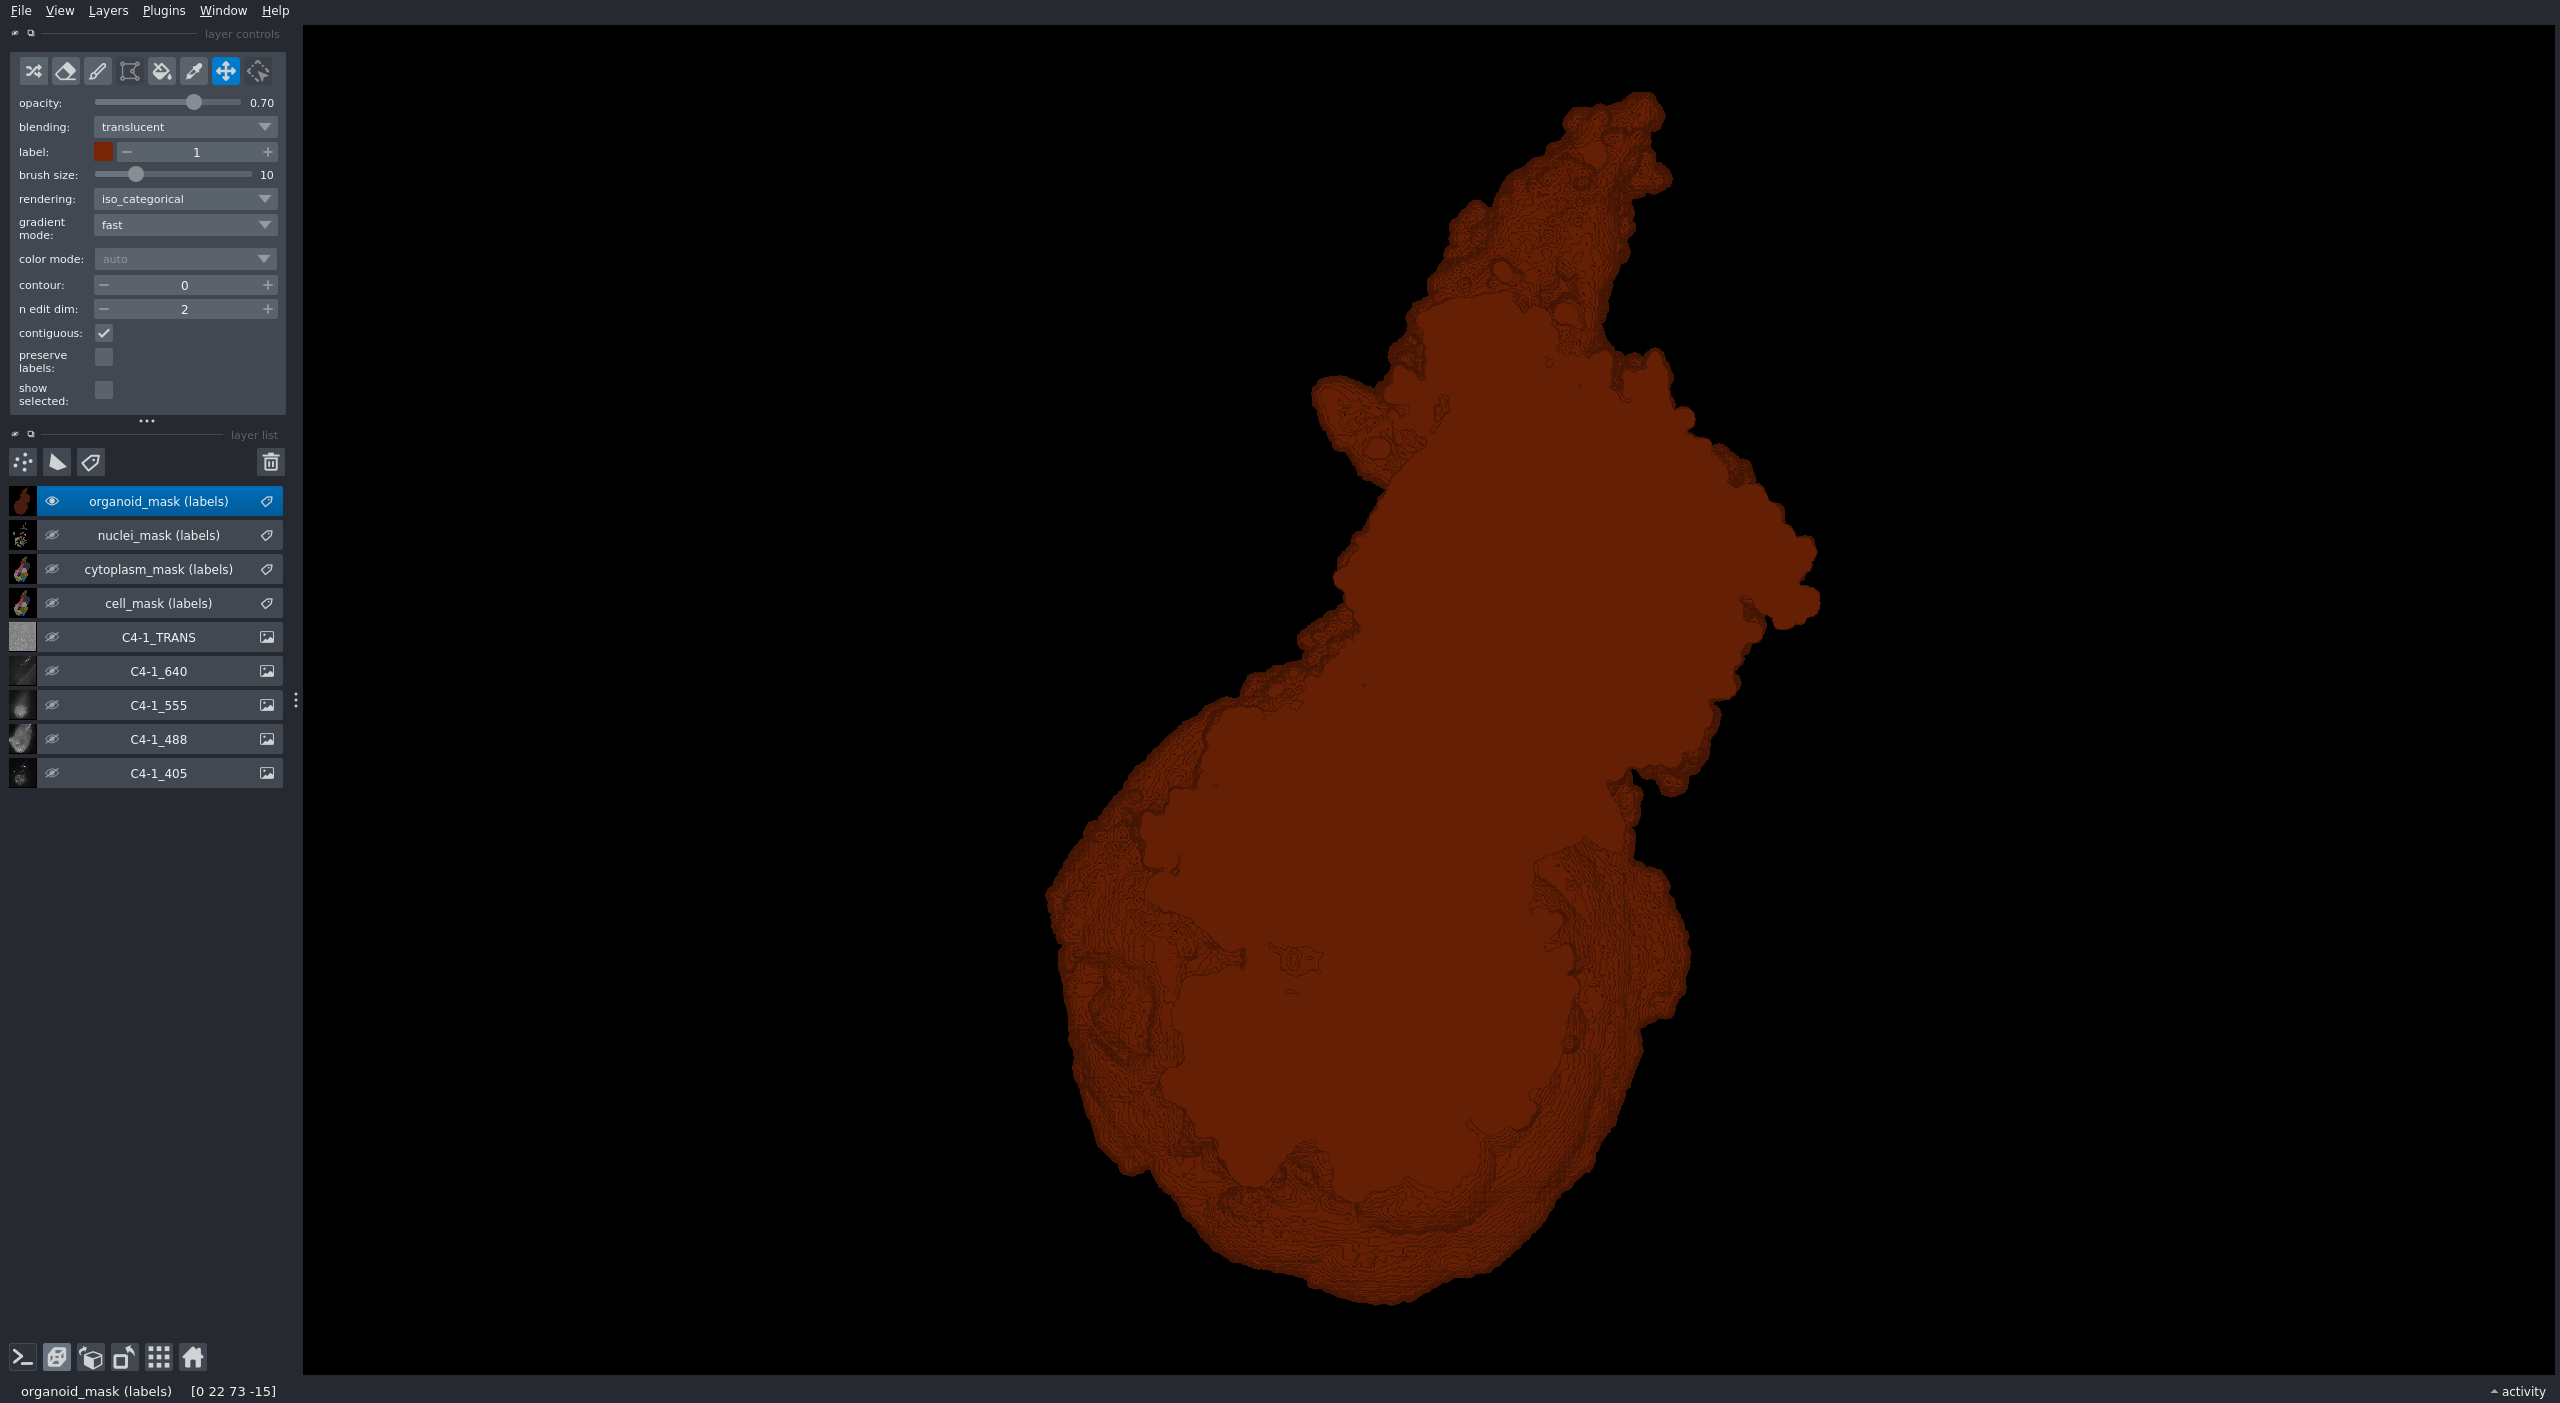

In [8]:
# screenshot the napari viewer
nbscreenshot(viewer)